
# **Product Recomendation System**

<span style="font-size: 16px;">
This project includes:

- Data Loading & Preprocessing  
- Exploratory Data Analysis (EDA)  
- Collaborative Filtering with Surprise Library  
- Matrix Factorization using SVD  
- Recommendation Generation for Users  
- Evaluation using RMSE and Precision@k  
</span>




In [3]:

!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505217 sha256=393d1c5d42fe93e482dae092b3aee54a53eb4dd4b9a24399935d51ab3d40ffff
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##Environment Setup & Imports

In [2]:
import os
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
os.chdir("/content/drive/MyDrive/ProductRecomendation")

In [5]:
!ls

Product_Recommendation_Clean.ipynb  README.md


In [3]:

file_path = '/content/drive/MyDrive/dataset/ratings_Electronics.csv'
df = pd.read_csv(file_path, names=['user_id', 'product_id', 'rating', 'timestamp'])

## Data Cleaning: Drop Unnecessary & Invalid Rows

In [4]:

df.drop('timestamp', axis=1, inplace=True)
df.drop_duplicates(subset=['user_id', 'product_id'], keep='last', inplace=True)
df.dropna(inplace=True)

In [23]:

df.head()

Data loaded and cleaned.


,user_id,product_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


 Unique Users: 4201696
 Unique Products: 476002


<ipython-input-26-948414771908>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


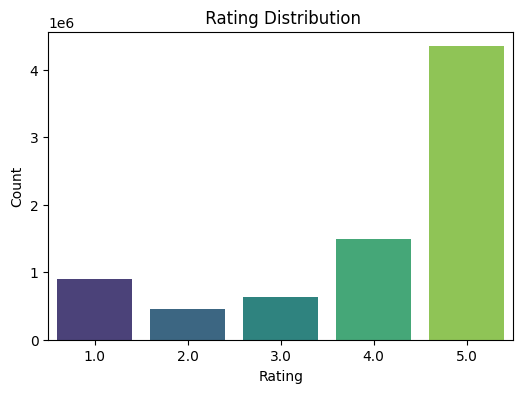

<ipython-input-26-948414771908>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.index, y=top_users.values, palette='coolwarm')


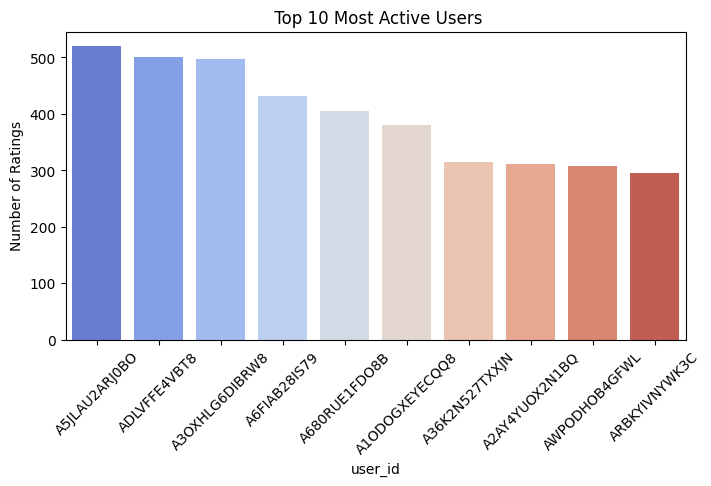

<ipython-input-26-948414771908>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.index, y=top_products.values, palette='magma')


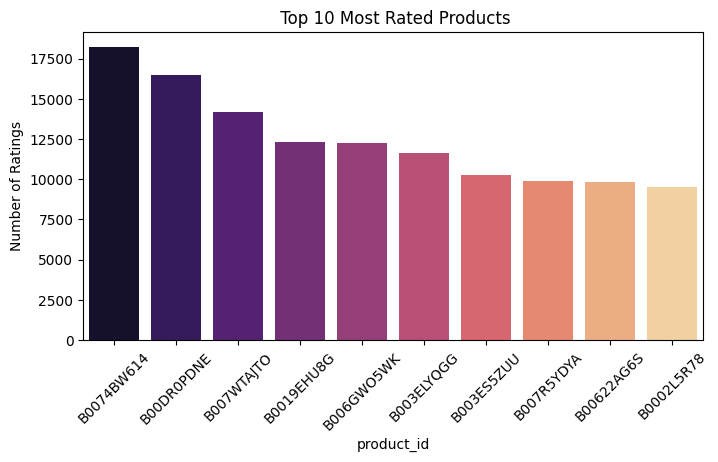

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of unique users and products
num_users = df['user_id'].nunique()
num_products = df['product_id'].nunique()
print(f" Unique Users: {num_users}")
print(f" Unique Products: {num_products}")

# Ratings distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title(" Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Top 10 most active users
top_users = df['user_id'].value_counts().head(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=top_users.index, y=top_users.values, palette='coolwarm')
plt.title(" Top 10 Most Active Users")
plt.xticks(rotation=45)
plt.ylabel("Number of Ratings")
plt.show()

# Top 10 most rated products
top_products = df['product_id'].value_counts().head(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=top_products.index, y=top_products.values, palette='magma')
plt.title(" Top 10 Most Rated Products")
plt.xticks(rotation=45)
plt.ylabel("Number of Ratings")
plt.show()


##Prepare Dataset for Surprise Library Using Reader

In [24]:

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'product_id', 'rating']], reader)

##Train-Test Split for Model Evaluation

In [7]:

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

##Train SVD Recommendation Model on Training Data

In [8]:
model = SVD()
model.fit(trainset)

##Evaluate SVD Model Performance Using RMSE

In [9]:

predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 1.2956


1.295553832262157

##Function to Recommend Top-N Products for a User





In [10]:
def recommend_products(user_id, model, df, n=5):
    all_products = df['product_id'].unique()
    rated_products = df[df['user_id'] == user_id]['product_id'].tolist()
    products_to_predict = [pid for pid in all_products if pid not in rated_products]

    predictions = [model.predict(user_id, pid) for pid in products_to_predict]
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    return [(pred.iid, round(pred.est, 2)) for pred in top_predictions]


##View Recommendations for a Sample User

In [11]:

sample_user = df['user_id'].iloc[24]
print("Recommendations for existing user: {sample_user}")
recommendations = recommend_products(sample_user, model, df)
for pid, rating in recommendations:
    print(f"Product: {pid}, Predicted Rating: {rating}")

Recommendations for existing user: {sample_user}
Product: B00000JBHE, Predicted Rating: 5
Product: B000067SMH, Predicted Rating: 5
Product: B0000W64XK, Predicted Rating: 5
Product: B00066U1AW, Predicted Rating: 5
Product: B000BY52NK, Predicted Rating: 5


##Fallback for New Users

In [12]:

def recommend_popular_products(df, n=5):
    top_products = (
        df.groupby('product_id')['rating']
        .count()
        .sort_values(ascending=False)
        .head(n)
    )
    return list(top_products.index)

##Popular Recommendations for Cold-Start Users

In [13]:

print(" Recommendations for new user:")
popular_products = recommend_popular_products(df)
for pid in popular_products:
    print(f"Popular Product: {pid}")

 Recommendations for new user:
Popular Product: B0074BW614
Popular Product: B00DR0PDNE
Popular Product: B007WTAJTO
Popular Product: B0019EHU8G
Popular Product: B006GWO5WK


In [14]:
user_input = df['user_id'].iloc[0]
recommendations = recommend_products(user_input, model, df)

for pid, rating in recommendations:
    print(f"Product: {pid}, Predicted Rating: {rating}")


Product: B00000J1V7, Predicted Rating: 5
Product: B000053HC5, Predicted Rating: 5
Product: B00006I5I2, Predicted Rating: 5
Product: B0000CCSDS, Predicted Rating: 5
Product: B0000DYV9H, Predicted Rating: 5


##Dataset Filtering for Better Model Accuracy

In [15]:

user_counts = df['user_id'].value_counts()
active_users = user_counts[user_counts >= 50].index
df_filtered = df[df['user_id'].isin(active_users)]

product_counts = df_filtered['product_id'].value_counts()
popular_products = product_counts[product_counts >= 50].index
df_filtered = df_filtered[df_filtered['product_id'].isin(popular_products)]

print("Filtered dataset shape:", df_filtered.shape)


Filtered dataset shape: (6234, 3)


##Model Comparison: SVD vs KNN vs NMF vs Baseline

In [19]:
from surprise import KNNBasic, NMF, BaselineOnly

reader = Reader(rating_scale=(1, 5))
data_filtered = Dataset.load_from_df(df_filtered[['user_id', 'product_id', 'rating']], reader)

trainset, testset = train_test_split(data_filtered, test_size=0.2, random_state=42)

models = {
    "SVD": SVD(),
    "KNNBasic": KNNBasic(),
    "NMF": NMF(),
    "BaselineOnly": BaselineOnly()
}

for name, algo in models.items():
    print(f"\nTraining model: {name}")
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions, verbose=False)
    print(f"{name} RMSE: {rmse:.4f}")



Training model: SVD
SVD RMSE: 0.8864

Training model: KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNBasic RMSE: 0.9263

Training model: NMF
NMF RMSE: 1.0393

Training model: BaselineOnly
Estimating biases using als...
BaselineOnly RMSE: 0.8831


##RMSE Bar Chart for Model Performance Comparison

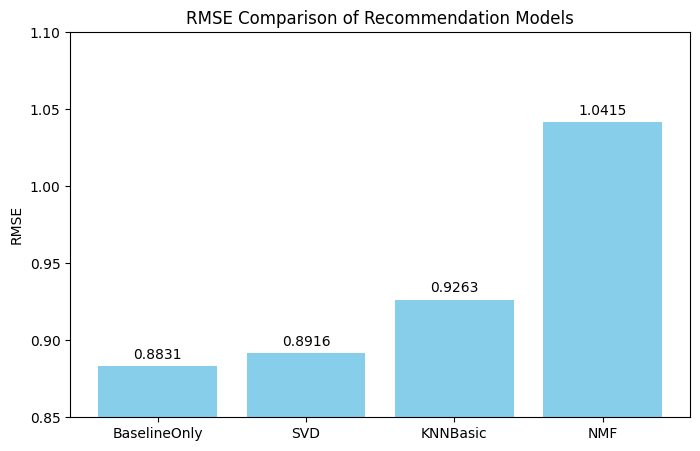

In [20]:
import matplotlib.pyplot as plt

model_names = ["BaselineOnly", "SVD", "KNNBasic", "NMF"]
rmse_scores = [0.8831, 0.8916, 0.9263, 1.0415]

plt.figure(figsize=(8, 5))
plt.bar(model_names, rmse_scores, color='skyblue')
plt.title("RMSE Comparison of Recommendation Models")
plt.ylabel("RMSE")
plt.ylim(0.85, 1.1)
for i, v in enumerate(rmse_scores):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center')
plt.show()


##Show User Rating History & Personalized Product Recommendations


In [21]:
def show_user_history_and_recommendations(user_id, model, df, n=5):
    print(f"\n User: {user_id}")

    # the user has already rated
    user_history = df[df['user_id'] == user_id]

    if user_history.empty:
        print(" New user — no ratings found.")
    else:
        print(f"\n🧾 Rated Products by {user_id}:")
        print(user_history[['product_id', 'rating']].head(10))  # Show first 10

    # Show recommendations
    recommendations = recommend_products(user_id, model, df, n=n)

    print(f"\n Top {n} Recommended Products (Not Yet Rated):")
    for pid, pred_rating in recommendations:
        print(f" Product ID: {pid} | Predicted Rating: {pred_rating}")


##existing user prediction

In [22]:
sample_user = df['user_id'].iloc[0]  # or any user ID that exists
show_user_history_and_recommendations(sample_user, model, df, n=5)



 User: AKM1MP6P0OYPR

🧾 Rated Products by AKM1MP6P0OYPR:
         product_id  rating
0        0132793040     5.0
5200191  B005UEB5TQ     5.0

 Top 5 Recommended Products (Not Yet Rated):
 Product ID: B00000J1V7 | Predicted Rating: 5
 Product ID: B000053HC5 | Predicted Rating: 5
 Product ID: B00006I5I2 | Predicted Rating: 5
 Product ID: B0000CCSDS | Predicted Rating: 5
 Product ID: B0000DYV9H | Predicted Rating: 5
